# NMT by jointly learning to align and translate(seq2seq with Attention)
- 논문코드(papers with code)
- [여기](https://github.com/graykode/nlp-tutorial)에 NLP tutorial이 엄청 자세하게 나와있다 + 논문

### 논문 내용 요약
- 기존의 RNN encoder-decoder 모델에 어떤 메커니즘(attention)을 추가한 모델을 제시한다.
---
## 1. Introduction
- NMT자체가 새로운 접근법이다.
    - 하나의 신경망을 학습시켜 기계 번역을 한다는 접근이 새롭게 떠오르는 방법이다.
- 지금까지 제시된 대부분의 NMT모델은 Encoder-Decoder 구조를 가진다.
    - Encoder가 입력 문장을 하나의 고정된 길이의 벡터로 encode한다.
    - Decoder는 그벡터를 가지고 번역을 생성한다.
- 가장 큰 문제는 Encoder가 입력 문장을 **고정된 길이의 벡터**로 바꾼다는 것이다.
    - 긴 문장이든 짧은 문장이든 어떤 고정된 길이의 벡터로 바꾸면, 그만큼 모델이 제 기능을 못할 가능성이 있다.
    - 실제로 입력 문장이 길어질수록 기존의 Encoder-Decoder 모델은 성능이 빠르게 저하된다.
- 따라서 본 연구는 align과 translate을 동시에 학습하는 모델을 제시한다.
    1. target이 예측될 때 source에서 어떤 부분을 참고하였는지에 대한 '관계성'(alignment)을 학습한다.
    2. 동시에 Translate 또한 학습.
    - 기존 모델이 가졌던 문제를 타파.
        - 즉, 고정된 길이의 벡터로 인코딩 하지 않는다.
        - 여러게의 벡터 시퀀스로 인코딩 하고 이 시퀀스들의 부분집합을 선택하여 target을 예측하게 된다.

## 2. Background: NMT
- 결국 NMT나 SMT 모두 입력 문장 x에 대한 출력 문장 y의 조건부 확률을 최대화 하는 방향을 추구한다.
    - NMT에서는 문장 쌍을 이용하여 조건부 확률 분포를 찾고 분포에서 값을 최대화 하는 target을 선택하는 방식으로 학습이 진행된다. 
    - 이전 연구에서 발표된 Encoder-Decoder 모델의 성능이 뛰어남
---
### 2-1. RNN encoder-Decoder
일반적인 RNN encoder-decoder 모델
1. Encoder는 입력문장을 읽고 벡터로 변환한다.
    - 입력문장 ${\bf x} = ( x_1, \cdots , x_{Tx} )$을 벡터 $c$로 변환
    - 은닉층 $h_t = f(x_t, h_{t-1})$
    - context vector $c = q(\{ h_1, \cdots, h_{Tx}\})$
    - $f, \space q$는 비선형 함수를 사용한다.
2. Decoder는 다음 단어  $y_{t'}$를 예측하기위해 훈련된다.
    - 입력으로 Encoder에서 생성된 벡터 $c$와 직전에 생성된 단어들 $\{y_1, \cdots, y_{t'-1}\}$을 받는다.
    - 즉, decoder는  결합 확률(joint probability)을 순차적인 조건부 확률(ordered conditionals)로 분해함으로써 번역 $\bf y$에 대한 확률을 정의한다.
        - 식:  $p({\bf y}) = \prod_{t=1}^Tp(y_t|\{y_1, \cdots, y_{t-1}\}, \space c)$ $\cdots$ (Equation.②)
        - $\bf y$는 입력 벡터들의 sequence임.
    - RNN에서 조건부 확률은 $p(y_t|\{y_1, \cdots, y_{t-1}\}, \space c) = g(y_{t-1}, s_t, c) \space \cdots$ (Equation.③)로 모델링 될 수 있다.
        - $g$는 다층으로 형성된 비선형 함수이고 $y_t$에 대한 확률을 계산하는 함수다.
        - $s_t$는 RNN의 은닉 상태의 벡터다.
        - 꼭 RNN이 아니어도 다른 구조들도 사용될 수 있다.(de-convolution neural network 같은 것들)
---
## 3. Learning to Align and Translation
- 본 연구에서 제안하는 새로운 NMT구조에 대해 설명한다.
    1. BiRNN(Encoder)
    2. Decoding 시에 source sentence에 attention

### 3-1. Decoder: General Description
- Attention mechanism을 사용하여 Encoder에서 source sentence의 모든 정보를 하나의 고정된 길이의 벡터로 바꿔야 하는 짐을 덜어주었다.
- 기존의 모델에서는 하나의 context vector $c$
- 하지만 본 연구가 제시한 모델에서는 **예측할(번역할) 각 단어$y_i$에 대하여 구별되는 맥락 벡터(context vector) $c_i$를 사용**
    - $c_i$는 Encoder가 매핑하는 입력 문장에 대한 annotation squence에 따라 달라진다.
        - annotation: $(h_1,\cdots,h_{Tx})$ 각각의 $h_i$는 입력 문장의 $i$번째 단어를 둘러싼 부분에 집중(focus)하여 전체 입력 시퀀스에 대한 정보를 포함.
    - 예측할 단어 $y_i$에 대한 context vector $c_i$는 annotation들과의 가중 합으로 계산. 
        - $c_i = \sum_{j=1}^{T_x}\alpha_{ij}h_j$ << expected annotation(모든 annotation들의 가중합)
        - $\alpha_{ij} = {\exp(e_{ij})\over\sum_{k=1}^{T_x}\exp(e_{ik})}$ << 가중치
        - $e_{ij} = a(s_{i-1}, h_j)$ << $h_j$의 중요도를 반영하는 값
            - $s_i$는 RNN에서 $i$번째 time step의 은닉 상태
            - $h_j$는 $j$번째 annotation
---
### 3-2. Encoder: BiRNN for annotation sequences
- annotation sequences가 어떻게 계산되는지에 대해 설명한다.
1. Forward RNN 은 입력 시퀀스를 순서대로 ($x_1$부터 $x_{Tx}$까지) 읽고 ***forward hidden state($\overrightarrow h_1, \cdots, \overrightarrow h_{Tx}$)***를 계산한다.
2. Backward RNN은 입력 시퀀스를 반대 순서로($x_{Tx}$부터 $x_1$까지) 읽고 ***backward hidden state(***$\overleftarrow h_1, \cdots, \overleftarrow h_{Tx}$***)***를 계산한다.
3. 마지막으로 $x_j$에 대한 *annotation($h_j$)*은 **forward와 backward의 concat**을 통해 얻을 수 있다. 즉, $h_j =$  $[\overrightarrow h_j^T ; \overleftarrow h_j^T]$이다.
    - 두 개의 행벡터를 쌓았다고 생각하자.
    - (벡터는 기본적으로 열벡터 표현이고, transpose했으니까 행벡터)
    - 세미콜론은 일반적으로 행의 끝을 의미,,
- 따라서 $h_j$라는 annotation은 앞 뒤 단어 모두에 대한 요약을 담고 있다.

C:\Users\alsrl\AppData\Local\Temp\ipykernel_2960\2135415625.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(attn_scores).view(1, 1, -1)


Epoch: 0040 cost = 0.014486
Epoch: 0080 cost = 0.004102
Epoch: 0120 cost = 0.002566
Epoch: 0160 cost = 0.001766
Epoch: 0200 cost = 0.001306
Epoch: 0240 cost = 0.001012
Epoch: 0280 cost = 0.000811
Epoch: 0320 cost = 0.000666
Epoch: 0360 cost = 0.000558
Epoch: 0400 cost = 0.000475
Epoch: 0440 cost = 0.000410
Epoch: 0480 cost = 0.000358
Epoch: 0520 cost = 0.000315
Epoch: 0560 cost = 0.000280
Epoch: 0600 cost = 0.000251
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


C:\Users\alsrl\AppData\Local\Temp\ipykernel_2960\2135415625.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
C:\Users\alsrl\AppData\Local\Temp\ipykernel_2960\2135415625.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


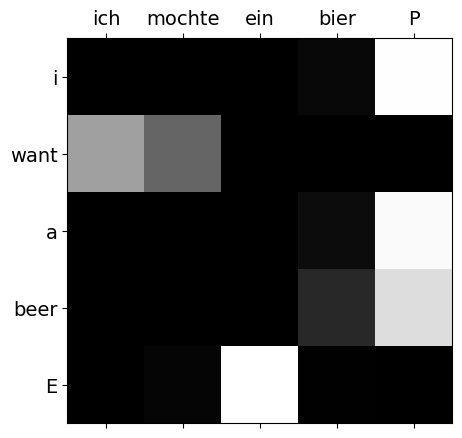

In [21]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(600):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 40 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='gray')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

### 코드 뜯어보기 ① make_batch
```python 
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
```
- input_batch 하나에 대해서 이해하면 output_batch도 똑같은 방식으로 이해 할 수 있다.
    - 먼저 np.eye(n)은 n x n identity matrix를 만든다.
    - 그 뒤에 대괄호로 인덱싱을 해주는 형식이다.
        - 그 인덱싱은 ```[word_dict[n] for n in sentences[0].split()]```이다. 
        - word_dict는 아마 단어가 숫자(index)와 함께 저장되어있는 dictionary이다.
        - 문장을 split()했으니 띄어쓰기로 나누었으므로 n은 하나의 단어가 된다.
    - 대충 예를 들어 생각해보면 np.eye(5)[[0, 1, 2, 3]]뭐 이런 형식이다.
        - 처음엔 이게 인덱싱이 되나 했지만, 된다.
        - 행, 열 인덱스를 동시에 주지 않으면 일단 '행'기준이라 생각하자
        - 따라서 5 x 5 항등행렬의 1, 2, 3, 4 행을 가져온다.
- output_batch도 마찬가지로 생각하자.
--- 
```python
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
```
- target_batch는 그냥 리스트안에 리스트가 있는 형식이다.
- return에서 전부 torch.Tensor형태로 바꿔준다.
    - Tensor 형태에 대해서는 [여기](https://pytorch.org/docs/stable/tensors.html)를 클릭
    - Float는 32-bit float, Long은 64-bit integar

### 코드 뜯어보기 ② class Attention, __init __
```python
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)
```
- 

In [7]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
word_dict ={'ich':0, 'mochte':1, 'ein':2, 'bier':3, 'P':4}
inputs = [np.eye(5)[[word_dict[n] for n in sentences[0].split()]]]
inputs

[array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])]

In [17]:
[[word_dict[n] for n in sentences[0].split()]]

[[0, 1, 2, 3, 4]]

In [10]:
np.eye(5)[[1, 2, 3, 4]]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [16]:
a = np.random.randn(3, 4)
print(a)
print(a[ :, [1, 2]])

[[ 1.63724063 -0.51011509 -0.52261814  1.42182023]
 [ 0.8045689   2.29169468  1.68847911 -0.3652619 ]
 [-1.21349768  0.73995342  0.12097152  1.37670112]]
[[-0.51011509 -0.52261814]
 [ 2.29169468  1.68847911]
 [ 0.73995342  0.12097152]]
